In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, gamma
from mpl_toolkits.mplot3d import Axes3D  
# Load in the MINERvA neutrino flux
df = pd.read_csv('MINERvA_Neutrino_fluxes.csv')

df2 = pd.read_csv('ND flux data.csv')


df=df[['Bin center', 'Flux', 'Error']]

for i in range(len(df)-1):
    df.loc[i, 'Flux'] = df.loc[i, 'Flux'] / (df.loc[i+1, 'Bin center'] - df.loc[i, 'Bin center'])

df.loc[len(df)-1, 'Flux'] = df.loc[len(df)-1, 'Flux'] / (df.loc[len(df)-1, 'Bin center'] - df.loc[len(df)-2, 'Bin center'])
   
df['Norm Flux']=df['Flux']/df['Flux'].sum()
df

,Bin center,Flux,Error,Norm Flux
0,0.25,8.840000e-06,5.020000e-07,1.509639e-04
1,0.75,1.468000e-05,6.120000e-07,2.506957e-04
2,1.25,2.333333e-05,5.540000e-07,3.984718e-04
3,1.55,9.230000e-05,6.380000e-07,1.576241e-03
4,1.65,1.130000e-04,7.660000e-07,1.929742e-03
...,...,...,...,...
123,57.50,1.786667e-09,3.640000e-09,3.051156e-08
124,65.00,5.420000e-10,1.720000e-09,9.255931e-09
125,75.00,1.550000e-10,4.710000e-10,2.646991e-09
126,85.00,3.560000e-11,1.270000e-10,6.079541e-10


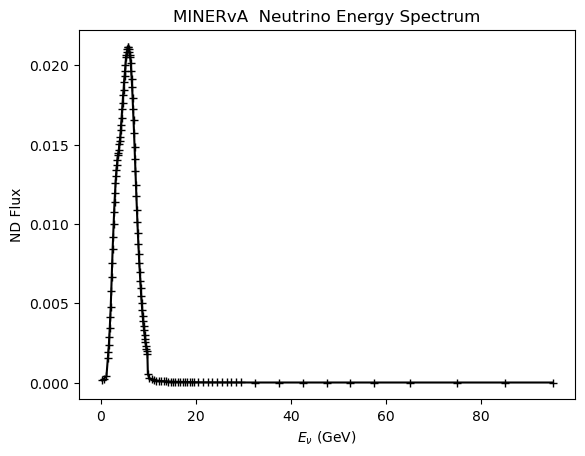

In [6]:
# ND data in Neutrinos/m2/1M POTs so need to divide by bin width to get density

df2['bin width']= df2['emax']-df2['#emin']
df2['norm flux']=df2['norm flux']/df2['bin width']

total_area = (df2['norm flux'] * df2['bin width']).sum()
df2['norm flux'] = df2['norm flux'] / total_area



plt.plot(df['Bin center'],df['Norm Flux'],color='black', marker='+')
plt.xlabel('$E_\\nu$ (GeV)')
plt.ylabel('ND Flux')
plt.title('MINERvA  Neutrino Energy Spectrum')
# plt.savefig('Expected NOvA adjusted E_nu energy spectrum.pdf',format='pdf')
plt.show()


In [13]:


def E_from_theta(E_pi, theta=0): 
    Gamma = E_pi * 1000 / m_pi   #factor of 1000 as using GeV
    return (.002 * E_star * Gamma ) / (1 + (Gamma * theta)**2)
    
def sample_pion_energy(params, N=50000, seed=42):
    rng = np.random.default_rng(seed)
    w1_raw, w2_raw, a1, scale1, mu2, sigma2, mu3, sigma3 = params

    # Normalize weights
    w1 = w1_raw
    w2 = w2_raw * (1 - w1)
    w3 = 1 - w1 - w2

    n1 = int(w1 * N)
    n2 = int(w2 * N)
    n3 = N - n1 - n2

    s1 = gamma.rvs(a=a1, scale=scale1, size=n1, random_state=rng)
    s2 = norm.rvs(loc=mu2, scale=sigma2, size=n2, random_state=rng)
    s3 = norm.rvs(loc=mu3, scale=sigma3, size=n3, random_state=rng)

    return np.concatenate([s1, s2, s3])

# p1 = np.random.normal(loc=pion_mean, scale=pion_stdv, size=int(samples*(1-gamma_proportion))) 
# p2 = rng.gamma(gamma_shape, scale=gamma_scale, size=int(samples*gamma_proportion))
# pions = np.concatenate((p1,p2), axis = 0)



pions = sample_pion_energy(params, samples, 42)

nus = E_from_theta(pions)
bin_mids = df['Bin center'][:-1].to_numpy() #have bin mids from MINERvA data but need edges to create histogram


edges = np.empty(len(bin_mids) + 1)
edges[1:-1] = (bin_mids[:-1] + bin_mids[1:]) / 2
edges[0] = bin_mids[0] - (bin_mids[1] - bin_mids[0]) / 2
edges[-1] = bin_mids[-1] + (bin_mids[-1] - bin_mids[-2]) / 2

pi_counts, bin_edges = np.histogram(pions, bins=edges)
counts, bin_edges = np.histogram(nus, bins=edges)

bin_widths = np.diff(edges)
pi_counts = pi_counts / (samples * bin_widths)
counts = counts / (samples * bin_widths)
measured = df['Norm Flux'][:127]

# Normalize both to area = 1
measured /= np.sum(measured * bin_widths)
counts /= np.sum(counts * bin_widths)


num_slices = int(1 + 2 * stdv_to_scan/slice_width)

time_window = 10000  #time to look at in ns
time_inc = 1 #time increment in ns
num_t = int(time_window/time_inc)

buckets = np.linspace(-stdv_to_scan, stdv_to_scan, num_slices)
time_steps = np.arange(0, time_window + time_inc, time_inc)
num_t = len(time_steps)

pion_dist = np.zeros((num_slices-1,3))
decay_pop = np.zeros((num_slices-1,num_t))


for i in range(num_slices-1):
    
    pion_dist[i,0] = pion_mean + pion_stdv * 0.5 *(buckets[i] + buckets[i+1]) #take midpoint of each slice as the pion energy
    pion_dist[i,1] = pion_dist[i,0] *1000/m_pi  #store the gammas for later use
    pion_dist[i,2] = norm.cdf(buckets[i+1], loc=0, scale=1) - norm.cdf(buckets[i], loc=0, scale=1) #calc the proportion of decays in this period
    # print(pion_dist[i,:])



for e in range(len(pion_dist)-1):
    E_pi = max(0,pion_dist[e,0])
    Gamma = E_pi*1000/m_pi

    for step, t in enumerate(time_steps):
        if step == 0:
            decay_prob = 1-np.exp(-t/(Gamma*tau_pi))
        else:  
            decay_prob= np.exp(-(t-time_inc)/(Gamma*tau_pi))- np.exp(-t/(Gamma*tau_pi))
        decay_pop[e,step] =  decay_prob  * pion_dist[e,2] 

def rebin_events_by_distance(events, speeds, dt=1.0, dd=1.0):
    """
    Redistribute events from time bins to distance bins via cumulative interpolation.
    This approach creates a continuous cumulative event function F(d) for each row,
    and then differentiates it to find the events per distance bin.
    
    Parameters:
      events: 2D numpy array of shape (n, t) with event counts.
              Each row is assumed to be events as a function of time.
      speeds: 1D numpy array of length n, the constant speed (in m/ns) for each row.
      dt: time bin width (ns).
      dd: desired distance bin width (m).
      
    Returns:
      distance_events: 2D numpy array of shape (n, num_distance_bins) with events binned by distance.
      max_distance: maximum distance covered over all rows.
      num_distance_bins: number of distance bins.
    """
    import numpy as np
    
    n, t = events.shape

    # For each row, determine the distance corresponding to each time bin midpoint.
    # We assume that events in a time bin occur at the midpoint.
    d_mid = np.empty((n, t))
    for i in range(n):
        # time bin midpoints: (j+0.5)*dt, j=0,...,t-1
        d_mid[i, :] = speeds[i] * (np.arange(t) + 0.5) * dt

    # Determine overall maximum distance
    max_distance = np.max(d_mid)
    
    # Define distance bin edges (from 0 to max_distance)
    distance_edges = np.arange(0, max_distance + dd, dd)
    num_distance_bins = len(distance_edges) - 1
    
    # Initialize the rebinned events array
    distance_events = np.zeros((n, num_distance_bins))
    
    # For each row, form a cumulative distribution function (CDF) in distance.
    # We pad with a zero at distance=0.
    for i in range(n):
        # Cumulative events as a function of time:
        cumulative = np.cumsum(events[i, :])
        # Pad with zero at the start (at d=0)
        cumulative = np.concatenate(([0], cumulative))
        # Pad the distance array accordingly. At time=0, distance=0.
        d_vals = np.concatenate(([0], d_mid[i, :]))
        # Interpolate the cumulative function at the defined distance edges.
        # This yields F(distance) at each edge.
        F_edges = np.interp(distance_edges, d_vals, cumulative, left=0, right=cumulative[-1])
        # The event count in each distance bin is the difference of the cumulative at its edges.
        distance_events[i, :] = np.diff(F_edges)
    
    return distance_events, max_distance, num_distance_bins

speeds = 0.3 * np.sqrt(1 - pion_dist[:,1]**-2)


dt = 1  # time bin width (ns)
dd = 1     # distance bin width (m)

# Rebin the events from time to distance
dist, max_d, n_bins = rebin_events_by_distance(decay_pop, speeds, dt, dd)

d_buckets = int(max_dist/dd)

E_star = 29.8
m_pi = 139.6
m_mu = 105.7

def E_from_theta(E_pi, theta=0): 
    Gamma = E_pi * 1000 / m_pi   #factor of 1000 as using GeV
    return (.002 * E_star * Gamma ) / (1 + (Gamma * theta)**2)


def apparent_target(E_pi, distance, rest_frame_coords):
    #distance is from target in lab rest frame
    Gamma = E_pi * 1000 / m_pi   #factor of 1000 as using GeV
    #convert co-ords to pion rest frame
    p1 = np.array([(rest_frame_coords[0][0]-distance)/Gamma, rest_frame_coords[0][1]])
    p2 = np.array([(rest_frame_coords[1][0]-distance)/Gamma, rest_frame_coords[1][1]])


    h=2 
    center = (p1 + p2) / 2.0
    d = np.linalg.norm(center)

    # The observer's direction (unit vector from the origin to the target center)
    u = center / d

    # Compute the vector connecting the two edge–centers.
    v = p2 - p1

    # Project v onto the plane perpendicular to the observer's line-of-sight.
    v_proj = v - np.dot(v, u) * u

    # The effective (face-on) width is the magnitude of this projected vector.
    width_projected = np.linalg.norm(v_proj)

    # Now, assuming the target is rectangular, its face-on area is:
    face_on_area = width_projected * h

    # Finally, using the small-angle approximation, the solid angle is:
    solid_angle = face_on_area / (d ** 2)

    return solid_angle

    
#create array of neutrino energies same shape as pion enrgy/distance array and limit bothe to max_dist

decay_dist = dist[:,:d_buckets]
neutrino_e = decay_dist * 0 #initialise the array
flux_area = decay_dist * 0 #initialise the flux array


detector_sections = []
decay_dists=[]
flux_by_dist = []

for section in range(len(l_opps)):
    l_opp = l_opps[section]
    # Reinitialize a new neutrino energy array for this geometry:
    nu_e_section = np.zeros_like(decay_dist)
    flux_area = np.zeros_like(decay_dist)
    
    for d in range(nu_e_section.shape[1]):
        theta = np.arctan(l_opp/(l_adj - dd*d))
        for e in range(nu_e_section.shape[0]):
            E_pi = pion_dist[e, 0]
            nu_e_section[e, d] = E_from_theta(E_pi, theta)
            flux_area[e,d]=apparent_target(E_pi, dd*d, rest_frame_coords)

    
    # Append a copy of the new arrays
    detector_sections.append(nu_e_section.copy())
    decay_dists.append(decay_dist.copy())
    flux_by_dist.append(flux_area.copy())
    


flat_decays = (np.array(decay_dists)*np.array(flux_by_dist)).flatten()

flat_nu_e = np.array(detector_sections).flatten()

e_max = flat_nu_e.max()
e_min = flat_nu_e.min()

e_max = flat_nu_e.max()
e_min = flat_nu_e.min()

bins = np.arange(round(e_min - 0.1,1), round(e_max + 0.5,1), 0.1)
bin_widths = bins[1:]-bins[:-1]

hist, bin_edges = np.histogram(flat_nu_e, bins=bins, weights=flat_decays, density = True)
bin_widths = np.diff(bin_edges)
hist = hist / np.sum(hist * bin_widths)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# plt.bar(bin_centers, hist, width=np.diff(bin_edges), align='center', edgecolor='black')
plt.xlim(0,5)
#plt.ylim(0,.015)

plt.plot(df['Bin center'],df['Norm Flux'],color='black', marker='+')
plt.plot(bin_centers, hist, color='red', linestyle='-', 
         linewidth=2, label='Line Graph')
plt.xlabel('$E_\\nu$ (GeV)')
plt.ylabel('Relative Flux')
plt.title('MINERvA Adjusted Neutrino Energy Spectrum')
#plt.savefig('Expected NOvA adjusted E_nu energy spectrum.pdf',format='pdf')
plt.show()

NameError: name 'pion_mean' is not defined

In [11]:
E_star = 29.8
m_pi = 139.6
m_mu = 105.7
tau_pi = 26
max_dist = 450
samples = 100000

l_adj = 1000
l_opp = 0
l_adjs = 1000
l_opps = np.linspace(12.6, 14.6,11)
#l_opps = [12]
rest_frame_coords = [np.array([1000, -1.0]),np.array([1000, 1.0])]
stdv_to_scan = 2.0
slice_width = 0.1
params =np.array( [ 0.35,  0.97 ,  8.3,  1.1, 14.7, 3.5 , 25,  2.0])



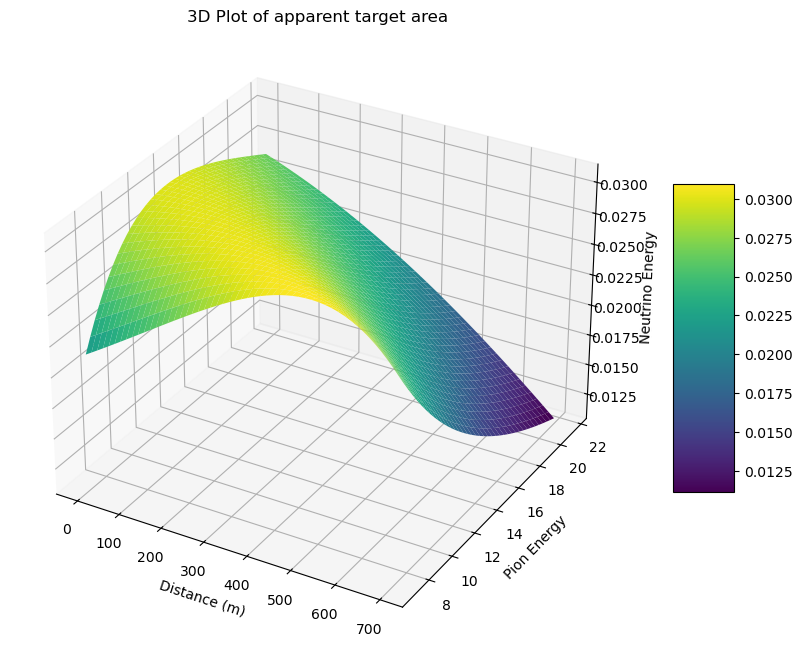

In [171]:
d_vals = np.arange(neutrino_e.shape[1]) * dd 
p_vals = pion_dist[:,0]

X, Y = np.meshgrid(d_vals, p_vals)
Z = flux_area

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Pion Energy')
ax.set_zlabel('Neutrino Energy')
ax.set_title('3D Plot of apparent target area')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

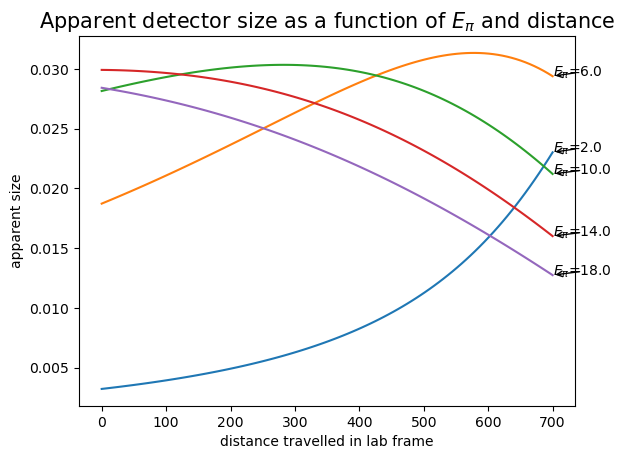

In [73]:
# Energy range of pions

dist = np.linspace(0,700,100)
E_pi = np.linspace(2,18,5)
rest_frame_coords = [np.array([1000, 12.6]),np.array([990, 16.6])]

fig, ax = plt.subplots()

for E in E_pi:
    target_size = []
    for d in dist:
        target_size.append(apparent_target(E, d, rest_frame_coords))
        
    ax.plot(dist, target_size)
    ax.annotate("$E_\\pi$="+str(E), xy=(dist[-1], target_size[-1]), xytext=(dist[-1]+.65, target_size[-1]), 
            arrowprops=dict(arrowstyle="->"))

ax.set_xlabel("distance travelled in lab frame")
ax.set_ylabel("apparent size")
plt.title(f"Apparent detector size as a function of $E_\\pi$ and distance", fontsize=15)

plt.savefig('apparent detector size.pdf',format='pdf')
plt.show()


In [19]:
dist = 600

for e in [2,4,6,8,10,12,14,16,18]:
    print (apparent_target(e, dist, rest_frame_coords))

0.0158698457919925
0.029760855277149768
0.03128505393626858
0.028625931630464146
0.02535479659841011
0.022398270597857255
0.019908314445456207
0.01784365734210309
0.016128271883046146


In [49]:
np.linspace(12.6,16.6,10)

array([12.6       , 13.04444444, 13.48888889, 13.93333333, 14.37777778,
       14.82222222, 15.26666667, 15.71111111, 16.15555556, 16.6       ])

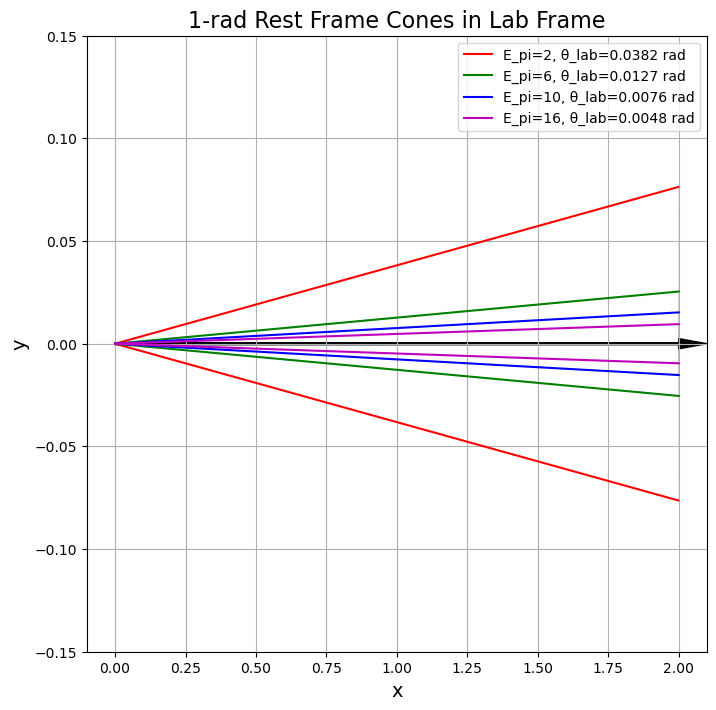

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Define the rest frame half-angle (radians)
theta_rest = 1.0

# List of Lorentz factors
gamma_list = [1, 10, 20, 50]
E_pi_list = [2, 6, 10, 16]

def lab_half_angle(E_pi, theta_rest):
    """
    Compute the lab-frame half-angle of a cone given its rest-frame half-angle (theta_rest)
    and Lorentz factor gamma using the aberration formula.
    """
    gamma =  E_pi * 1000 / m_pi   #factor of 1000 as using GeV
    beta = np.sqrt(1 - 1 / gamma**2)
    cos_theta_lab = (np.cos(theta_rest) + beta) / (1 + beta * np.cos(theta_rest))
    theta_lab = np.arccos(cos_theta_lab)
    return theta_lab

# Maximum distance out to draw the cones
L = 2.0

# Colors for different gamma values
colors = ['r', 'g', 'b', 'm']

plt.figure(figsize=(8, 8))

# Draw a reference arrow along the x-axis to indicate the forward (beam) direction
plt.arrow(0, 0, L, 0, head_width=0.005, head_length=0.1, fc='k', ec='k')

# Loop over the gamma values to compute and draw each cone
for i, E in enumerate(E_pi_list):
    theta_lab = lab_half_angle(E, theta_rest)
    # Endpoints for the top and bottom edges of the cone in the lab frame
    x_edge = L * np.cos(theta_lab)
    y_edge = L * np.sin(theta_lab)
    
    # Plot the two edges from the origin (0,0) to the end points.
    plt.plot([0, x_edge], [0, y_edge], color=colors[i],
             label=f'E_pi={E}, θ_lab={theta_lab:.4f} rad')
    plt.plot([0, x_edge], [0, -y_edge], color=colors[i])
    
    # Optionally, fill the cone region to illustrate the cone area.
    theta_vals = np.linspace(-theta_lab, theta_lab, 100)
    xs = L * np.cos(theta_vals)
    ys = L * np.sin(theta_vals)
    plt.fill_between(xs, ys, color=colors[i], alpha=0.1)

# Set plot limits and labels
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title('1-rad Rest Frame Cones in Lab Frame', fontsize=16)
plt.xlim(-0.1, L + 0.1)
plt.ylim(-.15, .15)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Cone plot.pdf',format='pdf')
plt.show()